In [1]:
import os
import math
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage.measure import find_contours
from skimage.transform import rotate
from scipy import ndimage as ndi

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

### Load data

In [2]:
def rotate_operators(operators, nb_rotations) :
    """
    Input : (1x5x40x40) array of five operators concatenated
    Output : (Nx5x40x40)  N arrays of five operators where they have been rotated N times to reach 360
    """
    #calculate the array of angles of rotations
    angle = 360/nb_rotations
    angles = np.linspace(angle,360-angle,nb_rotations-1)
    
    for a in angles :
        operators_rotated = np.empty((1,5,40,40))
        for idx,op in enumerate(operators[0]) :
            # rotate operators with bi-cubic interpolation
            operators_rotated[0,idx] = rotate(op,a,order =3)
            # binarize the resulting rotated opearators
            thresh = threshold_otsu(operators_rotated[0,idx])
            operators_rotated[0,idx] = operators_rotated[0,idx]>thresh
            operators_rotated[0,idx] = operators_rotated[0,idx].astype(float)
        # concatenate the five operators rotated by a certain angle to the array
        operators = np.concatenate([operators,operators_rotated],axis=0)
    return operators

In [3]:
def load_data(rotate=False,nb_rotation = 12) :
    """
    Load the five operators mask (40x40) -> plus,equal,minus,div,mul
    Output : (Nx5x40x40) array of operators :
                If no operators rotation : N=1 (1x5x40x40) -> [[plus,equal,minus,div,mul]]
                If operators are rotated : (Nx5x40x40) where N correspond to the number of rotation of each operator
                                            N = 360/ nb_rotation
    """
    
    # Load operators
    data_path = os.path.join('..\data')
    plus = skimage.io.imread(os.path.join(data_path, 'plus_bin.png'))
    equal = skimage.io.imread(os.path.join(data_path, 'equal_bin.png'))
    minus = skimage.io.imread(os.path.join(data_path, 'minus_bin.png'))
    div = skimage.io.imread(os.path.join(data_path, 'div_bin.png'))
    mul = skimage.io.imread(os.path.join(data_path, 'mul_bin.png'))
    
    # concatenate operators
    
    plus = np.expand_dims(plus,axis = 0)
    equal = np.expand_dims(equal,axis = 0)
    minus = np.expand_dims(minus,axis = 0)
    div = np.expand_dims(div,axis = 0)
    mul = np.expand_dims(mul,axis = 0)
    
    operators = np.concatenate([plus,equal,minus,div,mul], axis = 0)
    operators = np.expand_dims(operators,axis = 0)
    #rotation of the operators if true
    if (rotate == True) :
        operators = rotate_operators(operators,nb_rotation)
        
    return operators

In [4]:
operators = load_data(rotate=True)

C:\Users\seb\Anaconda3\envs\iapr2020\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


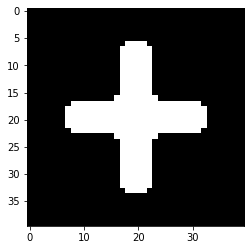

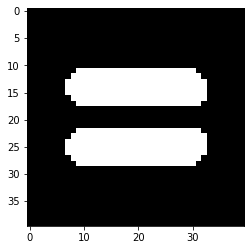

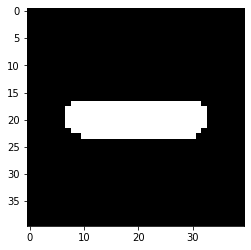

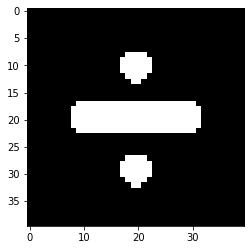

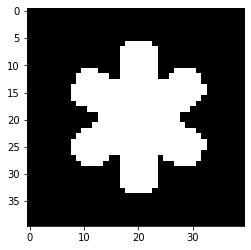

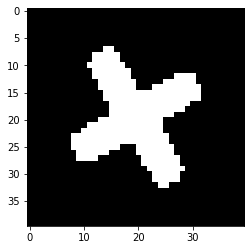

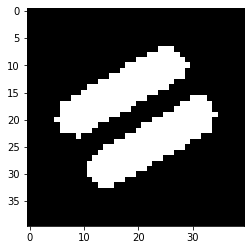

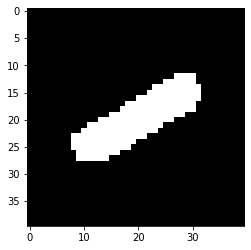

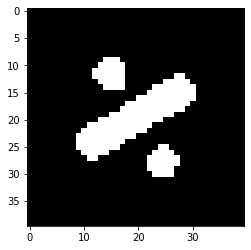

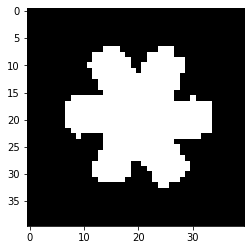

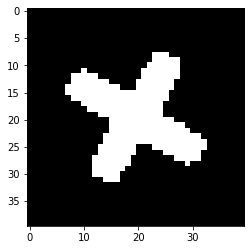

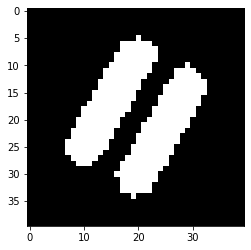

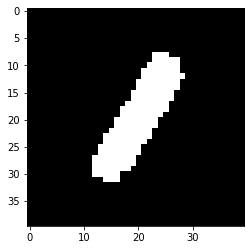

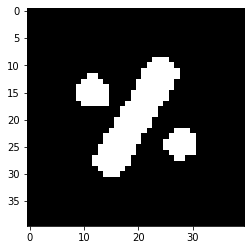

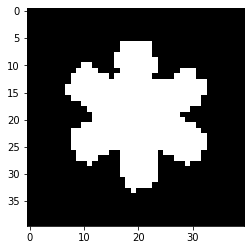

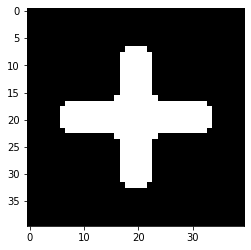

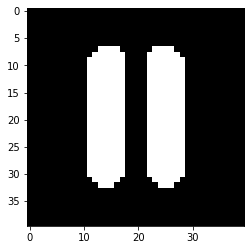

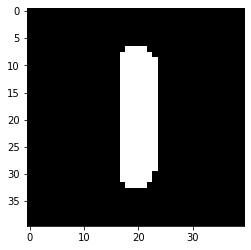

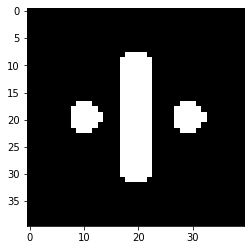

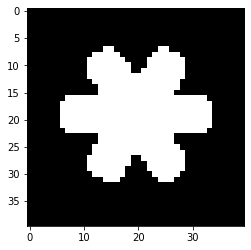

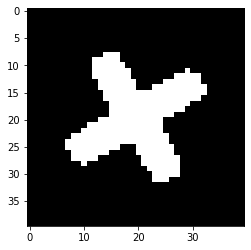

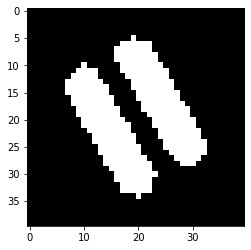

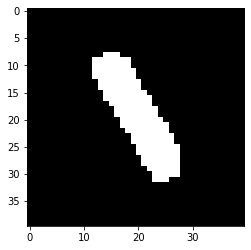

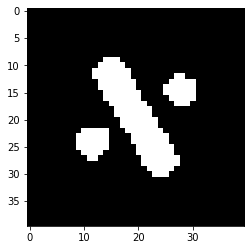

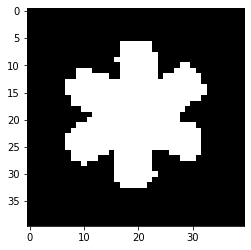

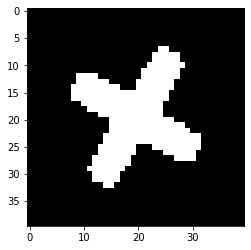

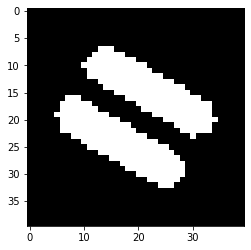

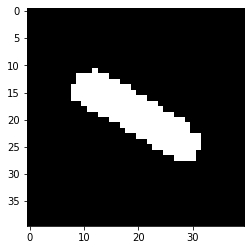

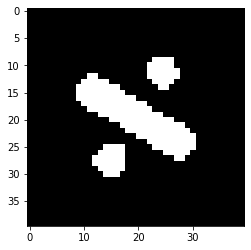

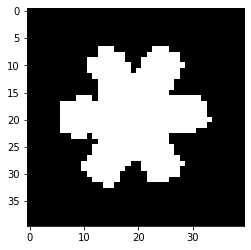

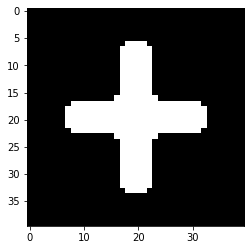

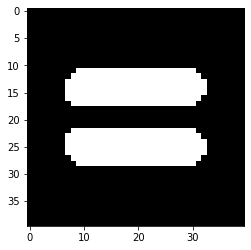

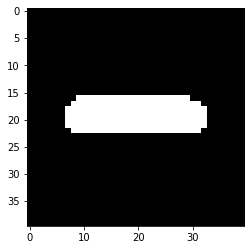

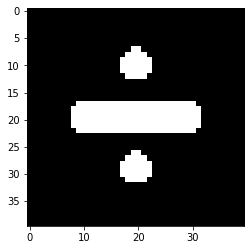

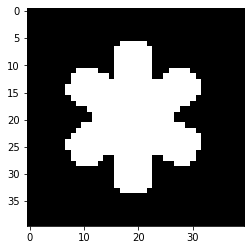

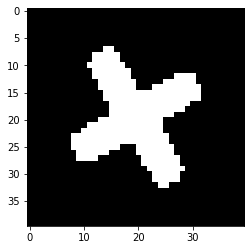

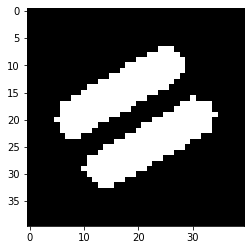

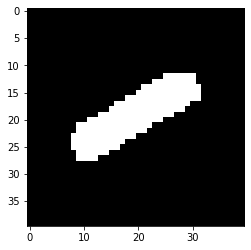

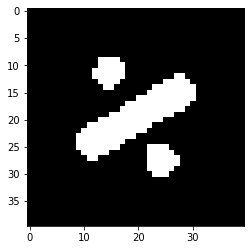

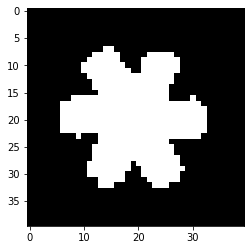

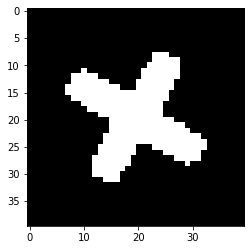

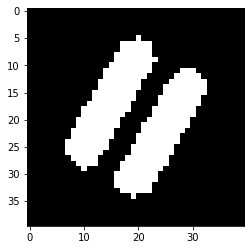

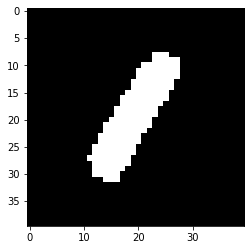

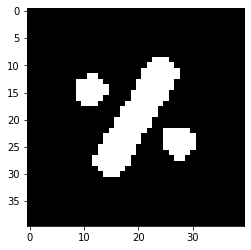

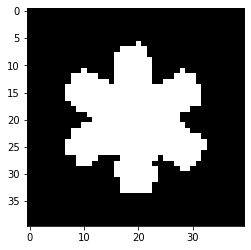

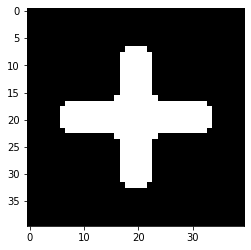

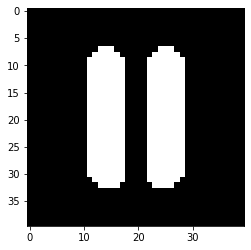

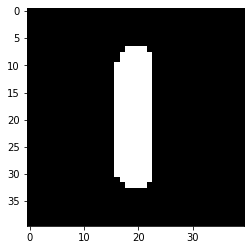

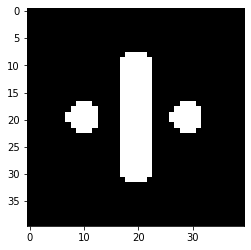

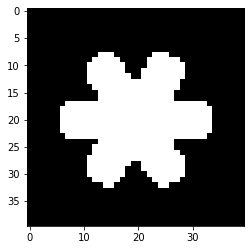

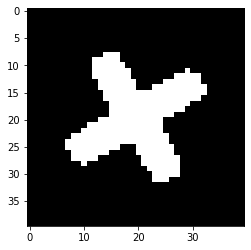

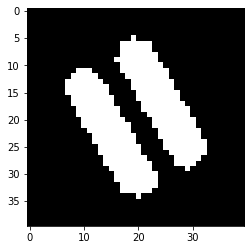

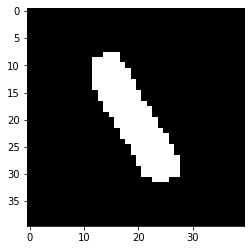

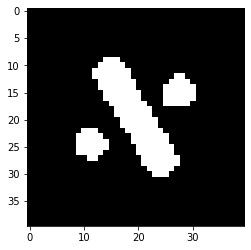

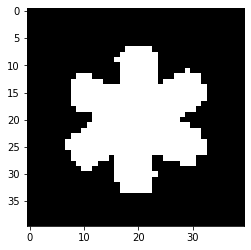

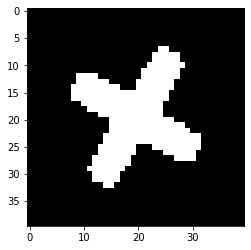

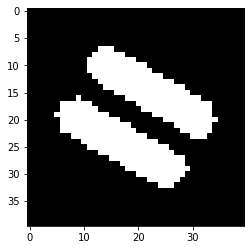

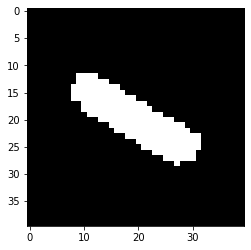

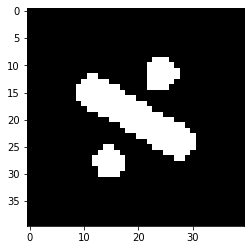

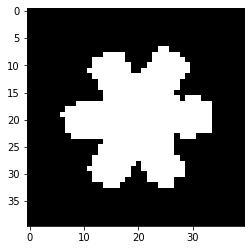

In [5]:
for n in range(operators.shape[0]) :
    for idx,op in enumerate(operators[n]) :
        plt.figure()
        plt.imshow(op,cmap='gray')

### Get features

In [6]:
def Fourier_descriptors (operators,Nb_coeff) :
    """
    Calculate the DFT of the operator's contour 
    Return the first N coefficient and the number of disjoint contours 
    """
    # get the contours
    contour = find_contours(operators,0.2)
    nb_contours = len(contour)
    if (nb_contours == 1) :
        contour = np.squeeze(np.asarray(contour))
        contour_complex = np.empty(contour.shape[0], dtype=complex)
        contour_complex.real = contour[:, 0]
        contour_complex.imag = contour[:, 1]
        fourier_result = np.fft.fft(contour_complex)
        DFT = np.fft.fft(contour_complex)
    if (nb_contours == 2) :
        contour_concatenated = np.concatenate((contour[0],contour[1]), axis=0)
        contour_complex = np.empty(contour_concatenated.shape[0], dtype=complex)
        contour_complex.real = contour_concatenated[:, 1]
        contour_complex.imag = contour_concatenated[:, 0]
        DFT = np.fft.fft(contour_complex)
    if (nb_contours == 3) :
        contour_concatenated = np.concatenate((contour[0],contour[1],contour[2]), axis=0)
        contour_complex = np.empty(contour_concatenated.shape[0], dtype=complex)
        contour_complex.real = contour_concatenated[:, 1]
        contour_complex.imag = contour_concatenated[:, 0]
        DFT = np.fft.fft(contour_complex)
    
    return DFT[:Nb_coeff], nb_contours

In [7]:
def get_features(operators,Nb_coeff,target =False ) :
    """
    Input : (Nx5x40x40) arrays of operators 
    Output : (5Nx4) arrays of features and (5N) arrays of target
            Features : First three features are ratio of the amplitude of fourier descriptor -> [A1/A2,A3/A2,A4/A2]
                       Last features is the number of disjoint contour -> plus,minus,mul : 1, equal : 2, div :3
    """
    
    # initialize the arrrays
    features = np.empty((operators.shape[0],operators.shape[1],4))
    targets = np.empty((operators.shape[0],5))
    print(operators.shape[0])
    #Loop over the array of operators to get the features and targets
    for N in range(operators.shape[0]) :
        for idx,op in enumerate(operators[N]) :
            # compute the features -> amplitude and first fourier descriptors excluded -> invariance in translation and rotation
            coeff,nb_contours = Fourier_descriptors(op,Nb_coeff)
            A1 = np.sqrt(coeff[1].real**2+coeff[1].imag**2)
            A2 = np.sqrt(coeff[3].real**2+coeff[3].imag**2)
            A3 = np.sqrt(coeff[4].real**2+coeff[4].imag**2)
            A4 = np.sqrt(coeff[2].real**2+coeff[2].imag**2)
            # compute ratios of Fourier descriptors -> scale invariant
            coord_x = (A1/A4)
            coord_y = (A2/A4)
            coord_z = (A3/A4)
            # concatenate the features 
            features[N,idx] = np.array([coord_x,coord_y,coord_z,nb_contours])
            targets[N,idx] = idx
    # reshape the arrays for the classification algorithm
    features = np.reshape(features,(operators.shape[0]*operators.shape[1],4))
    targets = np.reshape(targets,(operators.shape[0]*5))
    if (target == False) :
        return features
    if(target == True) :
        return features,targets

In [8]:
features,targets = get_features(operators,5,True)
print(features)
print(targets)

12
[[5.43292268e+00 2.40633314e+01 5.52076915e-01 1.00000000e+00]
 [3.71379313e-01 1.57825207e-01 8.86523397e-03 2.00000000e+00]
 [3.62054098e+01 1.85186492e+00 7.85355749e-01 1.00000000e+00]
 [2.07779396e-01 1.97150854e-01 2.31720255e-01 3.00000000e+00]
 [2.43614830e+00 1.87762622e+00 1.13185093e+00 1.00000000e+00]
 [8.67808411e+00 2.93886608e+01 6.50461044e-01 1.00000000e+00]
 [4.17709153e-01 1.49917346e-01 1.19057645e-02 2.00000000e+00]
 [3.22610580e+01 7.67515565e-01 6.83003490e-01 1.00000000e+00]
 [2.37099992e+00 1.38699974e+00 8.66916092e-01 3.00000000e+00]
 [4.45255541e+00 1.23526012e+00 1.09546915e+00 1.00000000e+00]
 [6.42443597e+00 2.72985700e+01 5.46241792e-01 1.00000000e+00]
 [4.39981657e-01 1.24335226e-01 6.29374782e-03 2.00000000e+00]
 [4.76339394e+01 8.31690219e-01 6.09643661e-01 1.00000000e+00]
 [1.86555111e-01 1.16408943e-01 1.22536812e-01 3.00000000e+00]
 [1.76148940e+00 2.07362715e-01 1.25254949e-01 1.00000000e+00]
 [3.34607323e+00 2.28402198e+01 4.75171284e-01 1.000

### K-nearest_neighbors classifier

In [9]:
#split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(features,targets, test_size=0.2, random_state=1)

Text(0, 0.5, 'Testing accuracy')

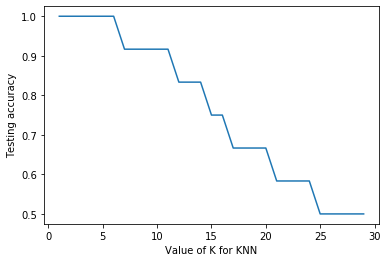

In [10]:
k_range = range(1,30)
scores = {}
scores_list = []
for k in k_range :
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    scores[k] = metrics.accuracy_score(y_test,y_pred)
    scores_list.append(metrics.accuracy_score(y_test,y_pred))
    
plt.plot(k_range,scores_list)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing accuracy')

In [11]:
#create new a knn model
knn_GS = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 20)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn_GS, param_grid, cv=5)
#fit model to data
knn_gscv.fit(features, targets)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [12]:
#check top performing n_neighbors value
print(knn_gscv.best_params_)
#check mean score for the top performing value of n_neighbors
print(knn_gscv.best_score_)

{'n_neighbors': 1}
1.0


In [13]:
# check result
print(knn_gscv.cv_results_)

{'mean_fit_time': array([0.00060005, 0.00080009, 0.        , 0.00100007, 0.00060005,
       0.        , 0.00080009, 0.00100007, 0.00099998, 0.00079999,
       0.00100012, 0.00100012, 0.00099998, 0.00080004, 0.00039997,
       0.00080004, 0.00100012, 0.00080009, 0.        ]), 'std_fit_time': array([4.89940316e-04, 4.00042545e-04, 0.00000000e+00, 1.90734863e-07,
       4.89940316e-04, 0.00000000e+00, 4.00042545e-04, 1.16800773e-07,
       9.53674316e-08, 3.99994861e-04, 1.78416128e-07, 1.78416128e-07,
       9.53674316e-08, 4.00018706e-04, 4.89862441e-04, 4.00018706e-04,
       9.53674316e-08, 4.00042545e-04, 0.00000000e+00]), 'mean_score_time': array([0.00280008, 0.00120006, 0.00099998, 0.0012001 , 0.00140004,
       0.0012001 , 0.00100002, 0.00100007, 0.00100017, 0.00100007,
       0.00099998, 0.00100002, 0.00100012, 0.00100007, 0.00140014,
       0.0012001 , 0.00099993, 0.00100007, 0.0012002 ]), 'std_score_time': array([7.48289989e-04, 4.00018735e-04, 9.53674316e-08, 3.99994861e-04,
 

In [37]:
# from gridsearchCV -> 1-NN best (but if look at result 1 to 18 yield 100 accuracy)
knn_tuned = KNeighborsClassifier(n_neighbors = 5)
knn_tuned.fit(features, targets)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [38]:
classes = {0:'addition',1:'equal',2:'minus',3:'division',4:'multiplication'}

In [39]:
# Load unseen operators
data_path = os.path.join('..\data')
plus_ = skimage.io.imread(os.path.join(data_path, 'plus.png'))
equal_ = skimage.io.imread(os.path.join(data_path, 'equal.png'))
minus_ = skimage.io.imread(os.path.join(data_path, 'minus.png'))
div_ = skimage.io.imread(os.path.join(data_path, 'div.png'))
mul_ = skimage.io.imread(os.path.join(data_path, 'mul.png'))

#thresh = threshold_otsu(operators_rotated[0,idx])
#operators_rotated[0,idx] = operators_rotated[0,idx]>thresh
#operators_rotated[0,idx] = operators_rotated[0,idx].astype(float)

plus_ = np.expand_dims(plus_,axis = 0)
equal_ = np.expand_dims(equal_,axis = 0)
minus_ = np.expand_dims(minus_,axis = 0)
div_ = np.expand_dims(div_,axis = 0)
mul_ = np.expand_dims(mul_,axis = 0)
    
operators_ = np.concatenate([plus_,equal_,minus_,div_,mul_], axis = 0)
operators_ = np.expand_dims(operators_,axis = 0)

for N in range(operators_.shape[0]) :
    for idx,op in enumerate(operators_[N]) : 
        thresh = threshold_otsu(op)
        op = op>thresh
        operators_[N,idx] = op.astype(float)
        

# get features

features_unseen = get_features(operators_,5)
print(features_unseen)

1
[[5.45441238e+00 2.48469150e+01 5.96227977e-01 1.00000000e+00]
 [3.78460154e-01 1.60096815e-01 8.67317032e-03 2.00000000e+00]
 [3.58715825e+01 1.88588314e+00 8.01137455e-01 1.00000000e+00]
 [2.08890870e-01 1.90470428e-01 2.27191509e-01 3.00000000e+00]
 [2.44048401e+00 1.96214759e+00 1.15137728e+00 1.00000000e+00]]


In [40]:
y_predict = knn_tuned.predict(features_unseen)

In [41]:
for y in y_predict:
    print(classes[y])

addition
equal
minus
division
multiplication


(1, 4, 50, 50)
(1, 4, 40, 40)
1
[[ 0.2287696   0.17114191  0.25850858  3.        ]
 [ 0.79634122 10.03601949  0.36641348  1.        ]
 [ 1.4017609   1.25941898  2.56203732  1.        ]
 [ 0.62854455  0.13531471  0.05721435  2.        ]]


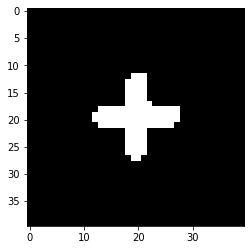

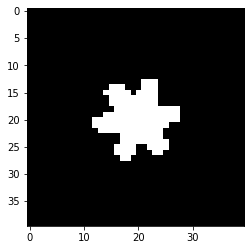

In [49]:
# operators cropped from the video
data_path = os.path.join('..\data')
crop1= skimage.io.imread(os.path.join(data_path, 'crop1.png'))
crop2 = skimage.io.imread(os.path.join(data_path, 'crop2.png'))
crop3 = skimage.io.imread(os.path.join(data_path, 'crop3.png'))
crop4 = skimage.io.imread(os.path.join(data_path, 'crop4.png'))

from skimage.color import rgb2gray
# convert in rgb in bw images 
crop1 = rgb2gray(crop1)
crop2 = rgb2gray(crop2)
crop3 = rgb2gray(crop3)
crop4 = rgb2gray(crop4)

# extend dim and concatenate
crop1 = np.expand_dims(crop1,axis = 0)
crop2 = np.expand_dims(crop2,axis = 0)
crop3 = np.expand_dims(crop3,axis = 0)
crop4 = np.expand_dims(crop4,axis = 0)
crop_operators = np.concatenate([crop1,crop2,crop3,crop4], axis = 0)
crop_operators = np.expand_dims(crop_operators,axis = 0)

print(crop_operators.shape)
from skimage.transform import resize

crop_operators_resized = np.empty((1,4,40,40))

for N in range(crop_operators.shape[0]) :
    for idx,op in enumerate(crop_operators[N]) : 
        op = resize(op,(40,40), anti_aliasing = True)
        thresh = threshold_otsu(op)
        op = op<thresh
        crop_operators_resized[N,idx] = op.astype(float)
print(crop_operators_resized.shape)

plt.figure()
plt.imshow(crop_operators_resized[0,1],cmap='gray')
plt.figure()
plt.imshow(crop_operators_resized[0,2],cmap='gray')

# get features

features_crop = get_features(crop_operators_resized,5)
print(features_crop)

In [50]:
y_predict_crop = knn_tuned.predict(features_crop)

for y_crop in y_predict_crop:
    print(y_crop)
    print(classes[y_crop])

3.0
division
4.0
multiplication
4.0
multiplication
1.0
equal
